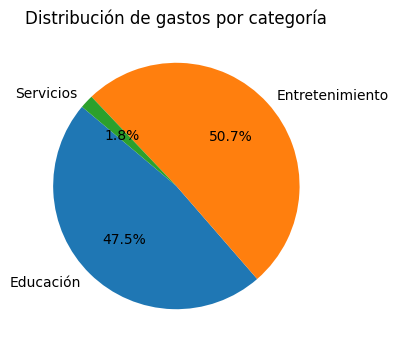

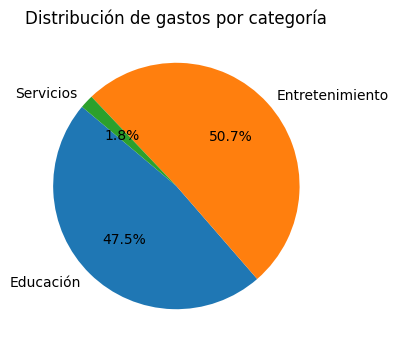

In [23]:
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from IPython.display import display
import json
import os
import tkinter as tk
from tkinter import ttk, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


# # --------------------- GUI ---------------------
# Crear ventana principal
ventana = tk.Tk()
ventana.title("Control de Gastos")
ventana.geometry("500x400")

# Título
titulo = tk.Label(ventana, text="Control de Gastos Personales", font=("Arial", 16))
titulo.pack(pady=10)

# Funciones de los botones
def registrar_ingreso():
    ingreso_ventana = tk.Toplevel(ventana)
    ingreso_ventana.title("Registrar Ingreso")
    ingreso_ventana.geometry("350x300")

    # Monto
    tk.Label(ingreso_ventana, text="Monto ($):").pack(pady=5)
    entrada_monto = tk.Entry(ingreso_ventana)
    entrada_monto.pack()

    # Descripción
    tk.Label(ingreso_ventana, text="Descripción:").pack(pady=5)
    entrada_descripcion = tk.Entry(ingreso_ventana)
    entrada_descripcion.pack()

    # Categoría
    tk.Label(ingreso_ventana, text="Categoría:").pack(pady=5)
    combo_categoria = ttk.Combobox(ingreso_ventana, values=categorias, state="readonly")
    combo_categoria.pack()

    # Fecha
    tk.Label(ingreso_ventana, text="Fecha (dd-mm-yyyy) [opcional]:").pack(pady=5)
    entrada_fecha = tk.Entry(ingreso_ventana)
    entrada_fecha.pack()
    
    # Botón para guardar
    def guardar_ingreso():
        try:
            monto = float(entrada_monto.get())
            descripcion = entrada_descripcion.get()
            categoria = combo_categoria.get()
            fecha = entrada_fecha.get().strip()

            if not descripcion or not categoria:
                messagebox.showwarning("Campos incompletos", "Por favor completa todos los campos obligatorios.")
                return

            if not fecha:
                fecha = datetime.now().strftime("%d-%m-%Y")

            transaccion = {
                "tipo": "ingreso",
                "monto": monto,
                "descripcion": descripcion,
                "categoria": categoria,
                "fecha": fecha
            }
            transacciones.append(transaccion)
            guardarTransacciones()
            messagebox.showinfo("Éxito", "Ingreso registrado correctamente.")
            ingreso_ventana.destroy()

        except ValueError:
            messagebox.showerror("Error", "Monto inválido.")

    tk.Button(ingreso_ventana, text="Guardar Ingreso", command=guardar_ingreso).pack(pady=10)


# Pantalla Gastos
def registrar_gasto():
    gasto_ventana = tk.Toplevel(ventana)
    gasto_ventana.title("Registrar Gasto")
    gasto_ventana.geometry("350x300")

    balance_actual = hacerBalance()
    if balance_actual <= 0:
      messagebox.showwarning("Sin fondos", "No tienes fondos disponibles para realizar gastos.")
      gasto_ventana.destroy()
      return
    label_balance = tk.Label(gasto_ventana, text=f"Saldo actual: ${balance_actual:.2f}", font=("Arial", 12, "bold"), fg="green")
    label_balance.pack(pady=5)
    
    # Monto a retirar 
    tk.Label(gasto_ventana, text="Monto($):").pack(pady=5)
    entrada_monto = tk.Entry(gasto_ventana)
    entrada_monto.pack()
    
    # Descripción
    tk.Label(gasto_ventana, text="Descripción [opcional]:").pack(pady=5)
    entrada_descripcion = tk.Entry(gasto_ventana)
    entrada_descripcion.pack()

    # Categoría
    tk.Label(gasto_ventana, text="Categoría:").pack(pady=5)
    combo_categoria = ttk.Combobox(gasto_ventana, values=categorias, state="readonly")
    combo_categoria.pack()

    # Fecha
    tk.Label(gasto_ventana, text="Fecha (dd-mm-yyyy) [opcional]:").pack(pady=5)
    entrada_fecha = tk.Entry(gasto_ventana)
    entrada_fecha.pack()
    
    # Botón para guardar
    def guardar_gasto():
        try:
            monto = float(entrada_monto.get())
            descripcion = entrada_descripcion.get()
            categoria = combo_categoria.get()
            fecha = entrada_fecha.get().strip()

            if not categoria:
                messagebox.showwarning("Campos incompletos", "Por favor completa todos los campos obligatorios.")
                entrada_descripcion.focus()
                return

            if monto > balance_actual:
                messagebox.showerror("Fondos insuficientes", f"No tienes suficiente saldo.\nSaldo actual: ${balance_actual:.2f}")
                return

            if not fecha:
                fecha = datetime.now().strftime("%d-%m-%Y")

            transaccion = {
                "tipo": "gasto",
                "monto": monto,
                "descripcion": descripcion,
                "categoria": categoria,
                "fecha": fecha
            }
            transacciones.append(transaccion)
            guardarTransacciones()
            messagebox.showinfo("Éxito", "Gasto registrado correctamente.")
            gasto_ventana.destroy()

        except ValueError:
            messagebox.showerror("Error", "Monto inválido.")

    tk.Button(gasto_ventana, text="Guardar Gasto", command=guardar_gasto).pack(pady=10)


def ventana_historial():
    historial_ventana = tk.Toplevel()
    historial_ventana.title("Historial de Transacciones")
    historial_ventana.geometry("1000x700")

    if not transacciones:
        messagebox.showinfo("Historial vacío", "Aún no hay transacciones registradas.")
        return

    df = pd.DataFrame(transacciones)
    df['fecha_dt'] = pd.to_datetime(df['fecha'], format="%d-%m-%Y", errors='coerce')
    df['mes'] = df['fecha_dt'].dt.strftime('%m-%Y')
    df['mes_nombre'] = df['fecha_dt'].dt.strftime('%B-%Y')
    df.sort_values(by="fecha_dt", ascending=False, inplace=True)

    meses_disponibles = sorted(df['mes_nombre'].dropna().unique())
    tipos_disponibles = ["todos", "ingreso", "gasto"]

    # ============ Filtros =============
    frame_filtros = tk.Frame(historial_ventana)
    frame_filtros.pack(pady=10)

    tk.Label(frame_filtros, text="Filtrar por mes:").grid(row=0, column=0, padx=5)
    mes_var = tk.StringVar()
    mes_dropdown = ttk.Combobox(frame_filtros, textvariable=mes_var, values=meses_disponibles, state="readonly")
    mes_dropdown.grid(row=0, column=1, padx=5)

    tk.Label(frame_filtros, text="Filtrar por tipo:").grid(row=0, column=2, padx=5)
    tipo_var = tk.StringVar(value="todos")
    tipo_dropdown = ttk.Combobox(frame_filtros, textvariable=tipo_var, values=tipos_disponibles, state="readonly")
    tipo_dropdown.grid(row=0, column=3, padx=5)

    def aplicar_filtro():
        mes = mes_var.get()
        tipo = tipo_var.get()
        df_filtrado = df.copy()

        if mes:
            df_filtrado = df_filtrado[df_filtrado['mes_nombre'] == mes]

        if tipo != "todos":
            df_filtrado = df_filtrado[df_filtrado['tipo'] == tipo]

        actualizar_tabla(df_filtrado)
        actualizar_resumen(df_filtrado, mes, tipo)
        actualizar_grafico(df_filtrado)

    btn_filtrar = tk.Button(frame_filtros, text="Filtrar", command=aplicar_filtro)
    btn_filtrar.grid(row=0, column=4, padx=10)

    btn_mostrar_todos = tk.Button(frame_filtros, text="Mostrar Todos", command=lambda: [
        mes_var.set(""), tipo_var.set("todos"), actualizar_tabla(df), actualizar_resumen(df, "", "todos"), actualizar_grafico(df)
    ])
    btn_mostrar_todos.grid(row=0, column=5, padx=10)

    # ============ Tabla de transacciones =============
    columnas = ("tipo", "monto", "descripcion", "categoria", "fecha")
    tabla = ttk.Treeview(historial_ventana, columns=columnas, show="headings")
    for col in columnas:
        tabla.heading(col, text=col.capitalize())
        tabla.column(col, width=120, anchor="center")
    tabla.pack(fill="both", expand=True, padx=10)

    tabla.tag_configure("ingreso", background="#d9fdd3")  # verde claro
    tabla.tag_configure("gasto", background="#fddada")    # rojo claro

    scrollbar = ttk.Scrollbar(tabla, orient="vertical", command=tabla.yview)
    tabla.configure(yscroll=scrollbar.set)
    scrollbar.pack(side="right", fill="y")

    def actualizar_tabla(df_filtrado):
        for item in tabla.get_children():
            tabla.delete(item)
        for _, row in df_filtrado.iterrows():
            tipo = row["tipo"]
            tag = tipo
            tabla.insert("", "end", values=(
                tipo,
                f"${row['monto']:.2f}",
                row["descripcion"],
                row["categoria"],
                row["fecha"]
            ), tags=(tag,))

    # ============ Resumen de gastos =============
    resumen_label = tk.Label(historial_ventana, text="", font=("Arial", 12))
    resumen_label.pack(pady=5)

    def actualizar_resumen(df_filtrado, mes, tipo):
        total_gastos = df_filtrado[df_filtrado['tipo'] == 'gasto']['monto'].sum()
        total_ingresos = df_filtrado[df_filtrado['tipo'] == 'ingreso']['monto'].sum()

        if tipo == "gasto" or tipo == "todos":
            if total_gastos > 0:
                resumen_label.config(text=f"Has gastado ${total_gastos:.2f} en el periodo seleccionado.")
            else:
                resumen_label.config(text="No se han registrado gastos en este periodo.")
        elif tipo == "ingreso":
            resumen_label.config(text=f"Has ingresado ${total_ingresos:.2f} en el periodo seleccionado.")
        else:
            resumen_label.config(text=f"Total ingresos: ${total_ingresos:.2f} | Total gastos: ${total_gastos:.2f}")

    # ============ Gráfica y tabla resumen =============
    frame_grafico = tk.Frame(historial_ventana)
    frame_grafico.pack(pady=10, fill="both", expand=True)

    def actualizar_grafico(df_graficas):
        for widget in frame_grafico.winfo_children():
            widget.destroy()

        df_gastos = df_graficas[df_graficas['tipo'] == 'gasto']
        df_ingresos = df_graficas[df_graficas['tipo'] == 'ingreso']

        # --- Gráfico Pie ---
        if not df_gastos.empty:
            resumen = df_gastos.groupby('categoria')['monto'].sum()
            colores = list(mcolors.TABLEAU_COLORS.values())[:len(resumen)]
            fig, ax = plt.subplots(figsize=(5, 4))
            ax.pie(resumen, labels=resumen.index, autopct='%1.1f%%', startangle=140, colors=colores)
            ax.set_title("Distribución de gastos por categoría")
            canvas = FigureCanvasTkAgg(fig, master=frame_grafico)
            canvas.draw()
            canvas.get_tk_widget().pack(side="left", padx=10)

        # --- Tabla resumen ingresos vs egresos por mes ---
        df_temp = df_graficas.copy()
        df_temp['mes_nombre'] = df_temp['fecha_dt'].dt.strftime('%B-%Y')
        resumen_mes = df_temp.groupby(['mes_nombre', 'tipo'])['monto'].sum().unstack(fill_value=0).reset_index()
        resumen_mes['balance'] = resumen_mes.get('ingreso', 0) - resumen_mes.get('gasto', 0)

        tabla_resumen = ttk.Treeview(frame_grafico, columns=("mes", "ingresos", "egresos", "balance"), show="headings", height=8)
        tabla_resumen.heading("mes", text="Mes")
        tabla_resumen.heading("ingresos", text="Ingresos")
        tabla_resumen.heading("egresos", text="Egresos")
        tabla_resumen.heading("balance", text="Balance")

        tabla_resumen.column("mes", width=140)
        tabla_resumen.column("ingresos", width=100, anchor="center")
        tabla_resumen.column("egresos", width=100, anchor="center")
        tabla_resumen.column("balance", width=100, anchor="center")

        tabla_resumen.tag_configure("positivo", background="#d9fdd3")  # verde claro
        tabla_resumen.tag_configure("negativo", background="#fddada")  # rojo claro

        for _, row in resumen_mes.iterrows():
            ingreso = row.get("ingreso", 0)
            gasto = row.get("gasto", 0)
            balance = row["balance"]
            tag = "positivo" if balance >= 0 else "negativo"

            tabla_resumen.insert("", "end", values=(
                row["mes_nombre"],
                f"${ingreso:.2f}",
                f"${gasto:.2f}",
                f"${balance:.2f}"
            ), tags=(tag,))

        tabla_resumen.pack(side="right", padx=10, fill="both", expand=True)

    # Mostrar datos por defecto
    actualizar_tabla(df)
    actualizar_resumen(df, "", "todos")
    actualizar_grafico(df)
def ver_balance():
    messagebox.showinfo("Balance", "Función para ver balance")

# Botones del menú
boton_ingreso = tk.Button(ventana, text="Registrar Ingreso", command=registrar_ingreso)
boton_ingreso.pack(pady=5)

boton_gasto = tk.Button(ventana, text="Registrar Gasto", command=registrar_gasto)
boton_gasto.pack(pady=5)

boton_historial = tk.Button(ventana, text="Ver Historial", command=ventana_historial)
boton_historial.pack(pady=5)

boton_balance = tk.Button(ventana, text="Ver Balance", command=ver_balance)
boton_balance.pack(pady=5)


# Ejecutar la app
ventana.mainloop()

# --------------------- Manejo del archivo .JSON ---------------------

def cargarTransacciones():
  if os.path.exists("transacciones.json"):
    with open("transacciones.json", "r") as archivo:
      return json.load(archivo)
  else:
    return []

def guardarTransacciones():
  with open("transacciones.json", "w") as archivo:
    json.dump(transacciones, archivo, indent=4)

# def descargarTransacciones():
#   try:
#     files.download("transacciones.json")
#   except Exception as e:
#     print(f"Error al descargar el archivo: {e}")


# --------------------- Bienvenida ---------------------

transacciones = cargarTransacciones()


# --------------------- Categorias ---------------------

categorias = [
    "Alimentación",
    "Transporte",
    "Entretenimiento",
    "Salud",
    "Educación",
    "Servicios",
    "Otros"
]

# --------------------- Menús ---------------------



# --------------------- Funciones  ---------------------

def seleccionarCategoria():
    print("\nSeleccione una categoría:")
    for i, cat in enumerate(categorias, 1):
        print(f"{i}. {cat}")
    while True:
        try:
            opcion = int(input("Número de categoría: "))
            if 1 <= opcion <= len(categorias):
                return categorias[opcion - 1]
            else:
                print("Opción inválida.")
        except ValueError:
            print("Ingrese un número válido.")

